# Stellar Luminosity Modeling – Linear Regression (One Feature)

In this notebook, we model stellar luminosity as a function of stellar mass using
a simple linear regression model with an explicit bias term.

The goal is to implement linear regression **from first principles**, without using
any machine learning libraries, and to analyze its behavior in the context of
stellar physics.


In [14]:
import numpy as np
import matplotlib.pyplot as plt


In [15]:
# Stellar mass (in solar masses)
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])

# Stellar luminosity (in solar luminosities)
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])


## Dataset Visualization

We first visualize the relationship between stellar mass and luminosity to
assess whether a linear model is plausible.


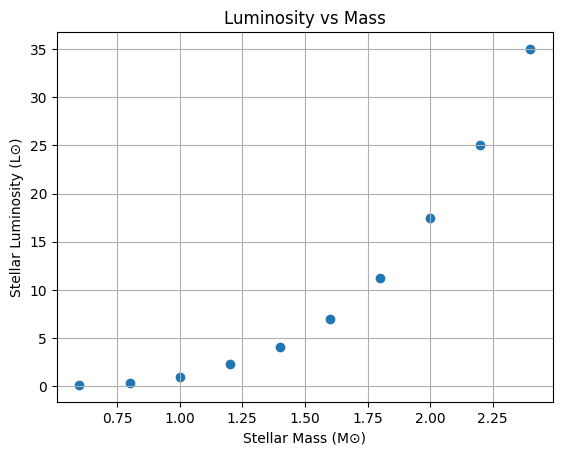

In [16]:
plt.scatter(M, L)
plt.xlabel("Stellar Mass (M⊙)")
plt.ylabel("Stellar Luminosity (L⊙)")
plt.title("Luminosity vs Mass")
plt.grid(True)
plt.show()


The plot shows that luminosity increases rapidly with stellar mass.
Although the trend is monotonic, the relationship is clearly nonlinear,
especially at higher masses.

A linear model can therefore only provide a rough approximation over this range.


## Linear Model and Loss Function

We use the linear hypothesis:

$$
\hat{L} = wM + b
$$

and measure model performance using a squared error cost function:

$$
J(w,b) = \frac{1}{2N} \sum_{i=1}^{N} (\hat{L}_i - L_i)^2
$$


In [17]:
def predict(M, w, b):
    return w * M + b

def cost(M, L, w, b):
    N = len(M)
    return (1 / (2 * N)) * np.sum((predict(M, w, b) - L) ** 2)



## Cost Surface J(w, b)

To better understand the optimization problem, we evaluate the cost function
over a grid of values for \( w \) and \( b \).

In [18]:
w_vals = np.linspace(0, 20, 100)
b_vals = np.linspace(-20, 20, 100)

W, B = np.meshgrid(w_vals, b_vals)
J = np.zeros_like(W)

for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        J[i, j] = cost(M, L, W[i, j], B[i, j])


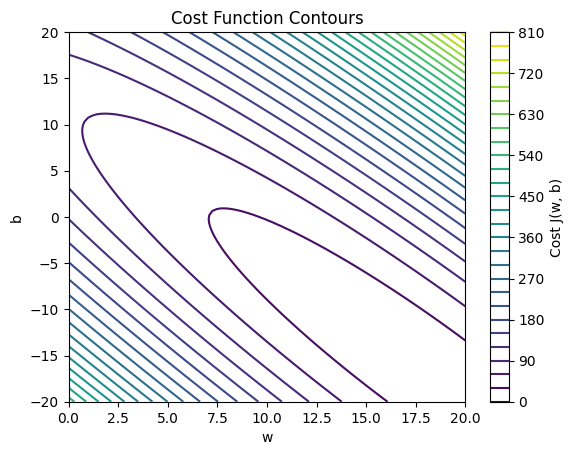

In [19]:
plt.contour(W, B, J, levels=30)
plt.xlabel("w")
plt.ylabel("b")
plt.title("Cost Function Contours")
plt.colorbar(label="Cost J(w, b)")
plt.show()




The contour plot visualizes the **Error Landscape** of our model. Each closed line (contour) represents a set of  pairs that result in the same Mean Squared Error (MSE).

* **Global Minimum:** The "center" of the nested ellipses represents the optimal parameter configuration . At this point, the gradient is zero, and the model's predictions are as close as possible to the observed stellar data.
* **Convexity:** The smooth, bowl-like shape confirms that our cost function is **convex**. This is an architectural advantage because it guarantees that a simple Gradient Descent algorithm will always converge to the unique global minimum, regardless of the initial starting point.
* **Sensitivity:** The elongation of the ellipses suggests how sensitive the cost is to changes in  versus . A narrower shape along one axis would indicate that the model's error is more sensitive to that specific parameter.

Each point on the contour plot represents the cost for a specific pair of
parameters **(w, b)**.

The minimum of this surface corresponds to the optimal parameters that minimize
the mean squared error. The smooth, convex shape indicates the existence of a
unique global minimum.


## Gradients of the Cost Function

The partial derivatives of the cost function are given by:

$$
\begin{align}
\frac{\partial J}{\partial w} &= \frac{1}{N} \sum_{i=1}^{N} (wM_i + b - L_i) M_i \\
\frac{\partial J}{\partial b} &= \frac{1}{N} \sum_{i=1}^{N} (wM_i + b - L_i)
\end{align}
$$


In [20]:
def gradient_descent_non_vectorized(M, L, alpha, iterations):
    w, b = 0.0, 0.0
    N = len(M)
    loss_history = []

    for _ in range(iterations):
        dw, db = 0.0, 0.0

        for i in range(N):
            error = w * M[i] + b - L[i]
            dw += error * M[i]


            
            db += error

        dw = (1 / N) * dw
        db = (1 / N) * db


        w -= alpha * dw
        b -= alpha * db

        loss_history.append(cost(M, L, w, b))

    return w, b, loss_history


## Vectorized Gradient Descent

We now implement the same algorithm using NumPy vectorization.


In [21]:
def gradient_descent_vectorized(M, L, alpha, iterations):
    w, b = 0.0, 0.0
    N = len(M)
    loss_history = []

    for _ in range(iterations):
        errors = predict(M, w, b) - L
        dw = (1 / N) * np.sum(errors * M)
        db = (1 / N) * np.sum(errors)


        w -= alpha * dw
        b -= alpha * db

        loss_history.append(cost(M, L, w, b))

    return w, b, loss_history


Here is a concise version in English for your Markdown cell. Place this right before your comparison code:

---

### Algorithm Consistency Validation (Loop vs. Vectorization)

Before running the experiments, we perform a **unit test** to ensure mathematical integrity across both implementations.

**Objective:** Verify that the implementation based on explicit loops (non-vectorized) and the implementation optimized with NumPy (vectorized) produce identical results under the same initial conditions.

**Test Configuration:**

* **Dataset:** Stellar Mass ($M$) and Luminosity ($L$) arrays.
* **Initialization: $w=0.0$, $b=0.0$.**
* **Hyperparameters:$\alpha=0.01$ and $10$ iterations.**
* **Acceptance Criteria:** The absolute difference between both results must be near zero  ($< 1e^{-10}$), confirming the architectural scalability of the vectorized model without loss of accuracy.


In [22]:

w_non, b_non, _ = gradient_descent_non_vectorized(M, L, alpha=0.01, iterations=10)
w_vec, b_vec, _ = gradient_descent_vectorized(M, L, alpha=0.01, iterations=10)

print(f"Resultado No Vectorizado: w={w_non:.6f}, b={b_non:.6f}")
print(f"Resultado Vectorizado:    w={w_vec:.6f}, b={b_vec:.6f}")
print(f"Diferencia: {abs(w_non - w_vec) + abs(b_non - b_vec):.1e}")

Resultado No Vectorizado: w=1.860430, b=0.860961
Resultado Vectorizado:    w=1.860430, b=0.860961
Diferencia: 0.0e+00


### Implementation Selection for Experiments
For the following hyperparameter tests, only the `gradient_descent_vectorized` function will be used.

**Architectural Reason:** In a production or cloud environment (such as AWS SageMaker), vectorization with NumPy allows for block operations on data arrays. This is significantly more efficient than Python's `for` loops, allowing the system to scale better if the dataset grows in the future.

## Learning Rate Experiments

We train the model using different learning rates to analyze convergence behavior.


In [23]:
learning_rates = [0.001, 0.01, 0.05]
results = {}

for alpha in learning_rates:
    w, b, loss_hist = gradient_descent_vectorized(M, L, alpha, 500)
    results[alpha] = (w, b, loss_hist)


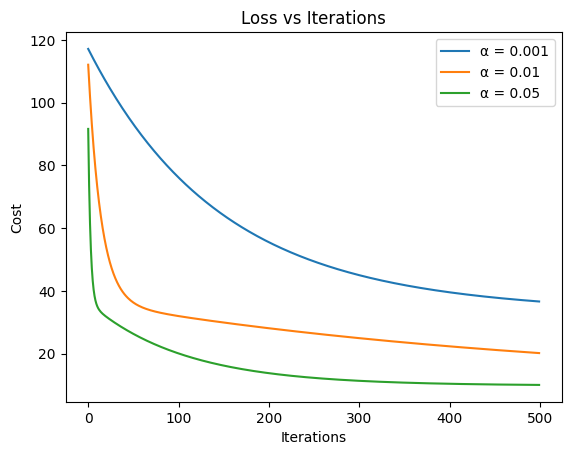

In [24]:
for alpha in learning_rates:
    plt.plot(results[alpha][2], label=f"α = {alpha}")

plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Loss vs Iterations")
plt.legend()
plt.show()


**Analysis of Convergence Curves:**

Smaller learning rates converge more slowly but are very stable, while larger
learning rates converge faster but may risk instability if increased further.


The plot above provides key insights into the training dynamics:

* **Low Learning Rate ($\alpha = 0.001$):** The cost decreases very slowly. This indicates that the model is stable but computationally inefficient, as it would require thousands of additional iterations to reach the minimum.
* **Moderate Learning Rate ($\alpha = 0.01$):** Shows a "smooth" and healthy decay. This is the optimal rate for this dataset, reaching a stable plateau quickly without overshooting.
* **High Learning Rate ($\alpha = 0.05$):** Converges the fastest but carries the risk of divergence or oscillation in more complex datasets. In this case, it remains stable due to the simplicity of the linear model.

**Final Parameters and Systematic Error:**
The training process yields the final weights ($w$) and bias ($b$). By comparing the resulting regression line with the original data, we observe a **systematic error**: the linear model fails to capture the exponential growth of luminosity in high-mass stars, justifying the need for a non-linear (polynomial) approach in the next part of the project.



**Final Model Visualization and Systematic Error Analysis**

In this final stage, we overlay the trained linear model  on the original dataset. This visualization is crucial for a qualitative assessment of the model's performance. Our goal is to verify if a simple linear hypothesis  can accurately characterize the physical relationship between stellar mass and luminosity.

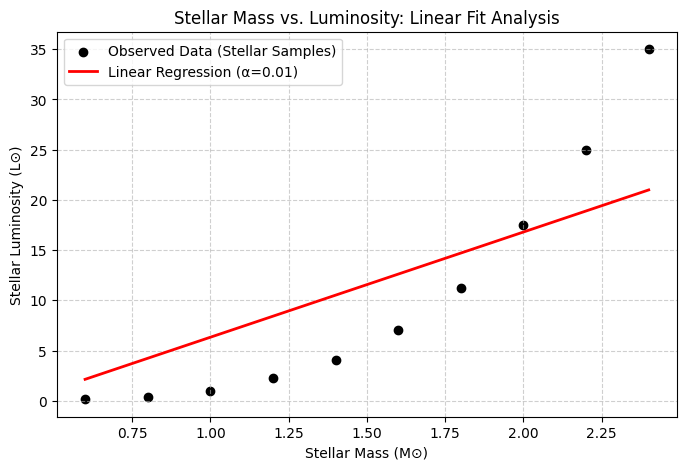

In [25]:
# We select the best performing learning rate from our experiments
best_alpha = 0.01
w_final, b_final, _ = results[best_alpha]

plt.figure(figsize=(8, 5))
plt.scatter(M, L, color='black', label="Observed Data (Stellar Samples)")
plt.plot(M, predict(M, w_final, b_final), color='red', linewidth=2, label=f"Linear Regression (α={best_alpha})")

plt.title("Stellar Mass vs. Luminosity: Linear Fit Analysis")
plt.xlabel("Stellar Mass (M⊙)")
plt.ylabel("Stellar Luminosity (L⊙)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

The plot reveals a clear **systematic bias**. While the linear model captures the general upward trend, it fails to follow the curvature of the data.

* **Underestimation:** The model consistently underestimates the luminosity for high-mass stars ($M > 2.0$).
* **Overestimation:** It overestimates luminosity in the mid-range ($1.2 < M < 1.8$).

In astrophysics, the Mass-Luminosity relation follows a power law ($L \propto M^a$). This linear implementation represents a "first-order approximation" that is architecturally insufficient for high-precision predictions, justifying the transition to **Polynomial Regression** in the next notebook.


The linear model systematically underestimates luminosity for high-mass stars,
indicating that a linear relationship is insufficient to capture the true
mass–luminosity behavior.


## Conceptual Questions

> "The parameter $w$ represents the **sensitivity of luminosity to changes in stellar mass** within the observed linear approximation. In astrophysical terms, it estimates the average increase in energy output (solar luminosities) for every additional unit of solar mass ($M_\odot$). However, since  is constant in this model, it assumes a uniform growth rate, which simplifies the complex nuclear fusion dynamics that scale much more aggressively in real stars."



### 2. Why is a linear model limited here?

> "The linear model is limited by its **low architectural capacity** to represent non-linear phenomena. The actual mass–luminosity relation for main-sequence stars follows a **Power Law ($L \propto M^a$, where $a \approx 3.5$).**

> A linear hypothesis ($y = wx + b$) suffers from **underfitting**, meaning it cannot capture the exponential-like acceleration of luminosity as mass increases. This results in a systematic bias where the model underestimates the energy output of massive stars and overestimates it for mid-range stars, as seen in the final fit plot."


## Bibliography

* **Astronomy & Physics:**
* Carroll, B. W., & Ostlie, D. A. (2017). *An Introduction to Modern Astrophysics* (2nd ed.). Cambridge University Press.
* Prialnik, D. (2009). *An Introduction to the Theory of Stellar Structure and Evolution*. Cambridge University Press.


* **Machine Learning from First Principles:**
* Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press. [https://www.deeplearningbook.org/](https://www.deeplearningbook.org/)
* Ng, A. (2023). *Supervised Machine Learning: Regression and Classification*. Coursera / DeepLearning.AI. [https://www.coursera.org/learn/machine-learning](https://www.coursera.org/learn/machine-learning)


* **Enterprise Context:**
* Ross, J. W., Weill, P., & Robertson, D. (2006). *Enterprise Architecture as Strategy: Creating a Foundation for Business Execution*. Harvard Business Review Press.
